In [1]:
import numpy as np
import math
from scipy import optimize
import matplotlib.pyplot as plt
from cycler import cycler

def net(mu, sigma, k, n, repeats=200):
    ks = []
    for i in range(0, repeats):
        latencies = np.random.normal(mu, sigma, n)
        latencies.sort()
        ks.append(latencies[k-1])
    return np.average(ks)

def mm1(lmda, mu):
    rho = lmda / mu
    L_q = rho ** 2 / (1 - rho)
    W_q = L_q / lmda
    return W_q

def md1(lmda, mu):
    rho = lmda / mu
    W_q = rho / (2 * mu * (1-rho))
    return W_q

def mg1(lmda, mu, sigma):
    rho = lmda / mu
    L_q = (lmda**2 * sigma**2 + rho**2) / (2 * (1 - rho))
    W_q = L_q / lmda
    return W_q

def gg1(lmda, mu, sigma_a, sigma_s):
    rho = lmda / mu
    C_a = sigma_a**2 / (1/lmda)**2
    C_s = sigma_s**2 / (1/mu)**2
    L_q = rho**2 * (1 + C_s) * (C_a + rho**2 * C_s) / (2 * (1-rho) * (1 + rho**2 * C_s))
    W_q = L_q / lmda
    return W_q

def sim(throughput, N, quorum, mu_lan, sigma_lan, mu_ser, sigma_ser, mu_des, sigma_des, queue_type):
    # lambda = throughput (requests/ms)
    lmda = throughput
    # service time = 2 serialization time + N deserialization time
    service = 2 * mu_ser + N * mu_des
    # mu = mean service rate (1/ms)
    mu = 1 / service
    
    sigma_s = math.sqrt(2 * sigma_ser ** 2 + N * sigma_des ** 2)
    sigma_a = 0.4 / lmda
    
    rtt = net(mu_lan, sigma_lan, quorum - 1, N - 1)
    
    W_q = {
        "mm1": mm1(lmda, mu),
        "md1": md1(lmda, mu),
        "mg1": mg1(lmda, mu, sigma_s),
        "gg1": gg1(lmda, mu, sigma_a, sigma_s)
    }.get(queue_type, "gg1")
    
    latency = W_q + service + rtt
    return latency

In [2]:
def curve(n, queue_type):
    service_time = 2 * mu_ser + n * mu_des
    throughput_max = int(1000.0 / service_time)
    latencies = []
    throughputs = []
    t = 500
    step = 500
    while t < throughput_max:
        throughputs.append(t)
        l = sim(throughput = t / 1000.0, # requests/ms
                N = n,
                quorum = int(n / 2 + 1),
                mu_lan = mu_lan,
                sigma_lan = sigma_lan,
                mu_ser = mu_ser,
                sigma_ser = sigma_ser,
                mu_des = mu_des,
                sigma_des = sigma_des,
                queue_type = queue_type
               )
        latencies.append(l)
        if t + 600 > throughput_max:
            step = 50
        t += step
    return throughputs, latencies

In [3]:
# LAN RTT normal distribution
mu_lan = 0.203 # ms
sigma_lan = 0.009 # ms
# serialization cost
mu_ser = 0.0023848 # ms
sigma_ser = 0.5 * mu_ser
mu_des = 0.01290492 # ms
sigma_des = 0.5 * mu_des

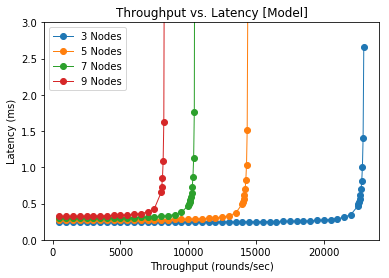

In [4]:
plt.xlabel('Throughput (rounds/sec)')
plt.ylabel('Latency (ms)')
plt.title('Throughput vs. Latency [Model]')
plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'k'])))

for n in range(3, 11, 2):
    x, y = curve(n, "gg1")
    plt.plot(x, y, marker='o', label=str(n) + " Nodes")


plt.ylim(0.0, 3.0)
plt.legend(loc='best')
plt.show()

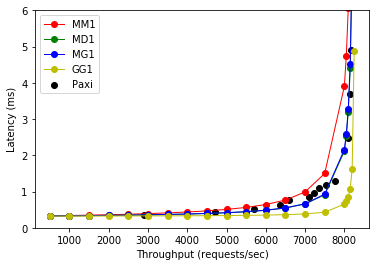

In [5]:
#plt.rcParams['figure.figsize'] = [10, 5]
plt.xlabel('Throughput (requests/sec)')
plt.ylabel('Latency (ms)')
plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'k'])))

paxi_x = np.array([2897.821033, 4700.363003, 5711.557828, 6351.055813, 6597.175963, 7112.43527, 7228.064433, 7348.416399, 7534.46842, 7749.696612, 8103.147209, 8138.567345, 8160.13128, 8177.766617])
paxi_y = np.array([0.342846, 0.423408, 0.523102, 0.62779, 0.755871, 0.841579, 0.966354, 1.086812, 1.192585, 1.287986, 2.464811, 3.68257, 4.899402, 6.110673])
#plt.plot(paxi_x, paxi_y, marker='o', label="Paxi")
plt.scatter(paxi_x, paxi_y, marker='o', c='k', label="Paxi")

x, y = curve(9, "mm1")
plt.plot(x, y, marker='o', label="MM1")

x, y = curve(9, "md1")
plt.plot(x, y, marker='o', label="MD1")

x, y = curve(9, "mg1")
plt.plot(x, y, marker='o', label="MG1")

x, y = curve(9, "gg1")
plt.plot(x, y, marker='o', label="GG1")

plt.ylim(0.0, 6.0)
plt.legend(loc='best')
plt.show()

[0.0023848  0.01290489]
[0.03367347 0.05202332 0.12688462 0.16877448 0.25892766 0.17639453
 0.2331674  0.26054105 0.2111543  0.05152421 0.31912041 0.10111435
 0.02089774 0.07361957]


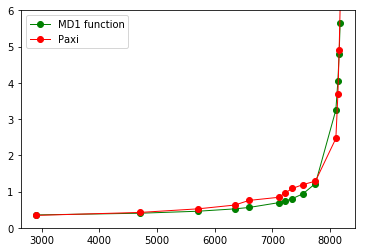

In [6]:
y = paxi_y[:]
x = paxi_x[:] / 1000.0
def f(x, cs, cd):
    rtt = net(mu_lan, sigma_lan, 4, 8)
    service = 2 * cs + 9 * cd
    mu = 1 / service
    return md1(x, mu) + service + rtt

params, params_covariance = optimize.curve_fit(f, x, y, p0=[mu_ser, mu_des])
plt.plot(paxi_x, f(paxi_x/1000.0, *params), 'go-', label='MD1 function')
plt.plot(paxi_x, paxi_y, marker='o', label="Paxi")
plt.ylim(0.0, 6.0)
plt.legend(loc='best')
print(params)

model_y = f(paxi_x/1000.0, *params)
err = abs(model_y - paxi_y) / paxi_y
print(err)